__Lab 04 - SCA (Part 1): Statistical Analysis__

Student Names: [insert your full name(s) here]

Group Number: [insert your group number as in Canvas here]

# Setup

## Importing Python Libraries & Setup ChipWhisperer

Begin by importing the required libraries, connecting to the scope, and applying the default setup:

In [62]:
%matplotlib notebook
import matplotlib.pyplot as plt
import chipwhisperer as cw
import numpy as np
import scipy.stats as sp
from tqdm import tnrange


# This is an API for your CW's scope (in the CAPTURE section)
scope = cw.scope()

# This is an API for your CW's target (in the TARGET section)
target = cw.target(scope, cw.targets.SimpleSerial)

# Sets the scope's default settings
scope.default_setup()

# Cap the max num of power trace samples to collect
scope.adc.samples = 500

# Prints the scope settings
print(scope)

print("✔️ OK to continue!")

See https://chipwhisperer.readthedocs.io/en/latest/api.html#firmware-update


Serial baud rate = 38400
ChipWhisperer Nano Device
fw_version = 
    major = 0
    minor = 24
    debug = 0
io = 
    tio1         = None
    tio2         = None
    tio3         = None
    tio4         = None
    pdid         = True
    pdic         = False
    nrst         = True
    clkout       = 7500000.0
    cdc_settings = None
adc = 
    clk_src  = int
    clk_freq = 7500000.0
    samples  = 500
glitch = 
    repeat     = 0
    ext_offset = 0

✔️ OK to continue!


Next, compile the firmware:

In [63]:
%%bash
cd ../Firmware
make PLATFORM=CWNANO CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
make clean_objs .dep 
make[1]: Entering directory '/home/phs/Desktop/phs-labs/PHS-Lab-04/Firmware'
SS_VER set to SS_VER_1_1

+--------------------------------------------------------

Removing old files
rm -f -- tvla-test-CWNANO.hex
rm -f -- tvla-test-CWNANO.elf
rm -f -- tvla-test-CWNANO.map
rm -f -- objdir-CWNANO/*.o
rm -f -- objdir-CWNANO/*.lst
rm -f -- tvla-test.s simpleserial.s stm32f0_hal_nano.s stm32f0_hal_lowlevel.s
rm -f -- tvla-test.d simpleserial.d stm32f0_hal_nano.d stm32f0_hal_lowlevel.d
rm -f -- tvla-test.i simpleserial.i stm32f0_hal_nano.i stm32f0_hal_lowlevel.i
make[1]: '.dep' is up to date.
make[1]: Leaving directory '/home/phs/Desktop/phs-labs/PHS-Lab-04/Firmware'
make begin gccversion build sizeafter
make[1]: Entering directory '/home/phs/Desktop/phs-labs/PHS-Lab-04/Firmware'
SS_VER set to SS_VER_1_1

+--------------------------------------------------------

Welcome to another exciting ChipWhisperer target build!!


arm-none-eabi-gcc (15:10.3

+--------------------------------------------------------
+ Output File: tvla-test-CWNANO.hex
+--------------------------------------------------------
make[1]: Leaving directory '/home/phs/Desktop/phs-labs/PHS-Lab-04/Firmware'


Program the microcontroller with the "tvla-test-CWNANO" hex file:

In [64]:
prog = cw.programmers.STM32FProgrammer
fw_path = '../Firmware/tvla-test-CWNANO.hex'
cw.program_target(scope, prog, fw_path)

print("✔️ OK to continue!")

Serial baud rate = 115200
Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5631 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5631 bytes
Serial baud rate = 38400
✔️ OK to continue!


## Function to Reset Target

This function allow you to reset the target from your code:

In [65]:
import time
def reset_target(): 
    target.flush()
    scope.io.nrst = 'low'
    time.sleep(0.2)
    scope.io.nrst = 'high'
    time.sleep(0.01)

Call this two function here:

In [66]:
reset_target()
print("✔️ OK to continue!")

✔️ OK to continue!


# Send/Read Data

Now that you have setup the CW, then send and read some data from the target. Use this to verify the functionality of your `tvla-test.c` firmware.

## Create a function to Send/Read Data

To make things easier, write a function that allows you to send data to and receive data from the target. You will use this many times.

In [67]:
# Function: get_data()
#   Input:  'data_in'  - input list of 16 positive integers from 0 to 255
#   Input:  'cmd'      - input character command to select the respective function from the CW
#   Output: 'data_out' - data read from the CW as bytearray
def get_data(data_in: list, cmd: str) -> bytearray:
    # reset target and read start-up text
    reset_target()
    
    # convert data_in list to bytearray
    bytelist = bytearray(data_in)
    
    # send the data_in as bytearray to the CW function with the respective 'cmd' parameter
    target.simpleserial_write(cmd, bytelist)
    
    # read data from CW
    r = target.simpleserial_read('r', 16)
    print(r)
    
    # return data read from the CW
    result = int.from_bytes(r, "big")
    data_out = result
    return data_out

Below, test your `get_data` function. Just test 1 input on 1 CW function (such as `tvla_test_A`) for now. Make sure it correctly sends and reads data.

In [68]:
d = [3, 5, 26, 22, 200, 12, 45, 23, 87, 43, 97, 157, 138, 234, 27, 2]
e = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


data = get_data(d, 'a')

print(data)

# do not change these lines below:
print("✔️ OK to continue!")

CWbytearray(b'00 00 00 00 00 00 00 00 00 00 00 00 3b 05 cc 00')
990235648
✔️ OK to continue!


## tvla_test_A

Test your `tvla_test_A` function. Send at least 3 different lists. Then, verify the results using python.

In [8]:
randlist1 = list(np.random.randint(low = 1,high=8,size=16))
randlist2 = list(np.random.randint(low = 1,high=8,size=16))
randlist3 = list(np.random.randint(low = 1,high=8,size=16))


#Test 1
data = get_data(randlist1, 'a')
product = 1
for i in randlist1:
    product = product * i
print("FPGA", data)
print("Product", product)
assert data == product

#Test 2
data = get_data(randlist2, 'a')
product = 1
for i in randlist2:
    product = product * i
print("FPGA", data)
print("Product", product)
assert data == product

#Test 3
data = get_data(randlist3, 'a')
product = 1
for i in randlist3:
    product = product * i
print("FPGA", data)
print("Product", product)
assert data == product







CWbytearray(b'00 00 00 00 00 00 00 00 00 00 00 00 02 04 cc 00')
FPGA 33868800
Product 33868800
CWbytearray(b'00 00 00 00 00 00 00 00 00 00 00 00 0f 25 97 70')
FPGA 254121840
Product 254121840
CWbytearray(b'00 00 00 00 00 00 00 00 00 00 00 00 06 0e 64 00')
FPGA 101606400
Product 101606400


## tvla_test_B

Test your `tvla_test_b` function. Send at least 3 different lists. Then, verify the results using python.

In [9]:
randlist1 = list(np.random.randint(low = 1,high=8,size=16))
randlist2 = list(np.random.randint(low = 1,high=8,size=16))
randlist3 = list(np.random.randint(low = 1,high=8,size=16))

#Test 1
data = get_data(randlist1, 'b')
xor = 0
for i in randlist1:
    xor = xor ^ i
print("FPGA Test 1:", data)
print("xor", xor)
assert data == xor

#Test 2
data = get_data(randlist2, 'b')
xor = 0
for i in randlist2:
    xor = xor ^ i
print("FPGA Test 2:", data)
print("xor", xor)
assert data == xor

#Test 3
data = get_data(randlist3, 'b')
xor = 0
for i in randlist3:
    xor = xor ^ i
print("FPGA Test 3:", data)
print("xor", xor)
assert data == xor

CWbytearray(b'00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 01')
FPGA Test 1: 1
xor 1
CWbytearray(b'00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 04')
FPGA Test 2: 4
xor 4
CWbytearray(b'00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 03')
FPGA Test 3: 3
xor 3


## tvla_test_C (graduate students only)

Test your `tvla_test_c` function. Send at least 3 different lists. Then, verify the results using python.

In [10]:
randlist1 = list(np.random.randint(low = 1,high=8,size=16))
randlist2 = list(np.random.randint(low = 1,high=8,size=16))
randlist3 = list(np.random.randint(low = 1,high=8,size=16))

#Test 1
data = get_data(randlist1, 'c')
product = 1
prod_mod = 0
for i in randlist1:
    product = product * i
    prod_mod = product % 251
print("FPGA Test 1:", data)
print("Mod", prod_mod)
assert data == prod_mod

#Test 2
data = get_data(randlist2, 'c')
product = 1
prod_mod = 0
for i in randlist2:
    product = product * i
    prod_mod = product % 251
print("FPGA Test 2:", data)
print("Mod", prod_mod)
assert data == prod_mod

#Test 3
data = get_data(randlist3, 'c')
product = 1
prod_mod = 0
for i in randlist3:
    product = product * i
    prod_mod = product % 251
print("FPGA Test 3:", data)
print("Mod", prod_mod)
assert data == prod_mod

CWbytearray(b'00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 49')
FPGA Test 1: 73
Mod 73
CWbytearray(b'00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 0e')
FPGA Test 2: 14
Mod 14
CWbytearray(b'00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 47')
FPGA Test 3: 71
Mod 71


# Record & Plot Traces

Now that you can communicate with your system and the firmware are correct, our next goal is to get a power trace while the target is running. To do this, you'll arm the scope just before you send the data, then record the trace as you did in the tutorial.

## Create a function to capture power traces

To make things easier, write a function that allows you to send data to the target and return the power trace generated by the CW. You will use this many times.

Hint: it is similar to the `get_data` function from before, but instead of reading data from the CW, you are capturing power traces.

In [11]:
# Function: get_pwr_trace()
#   Input:  'data_in'  - input list of 16 positive integers from 0 to 255
#   Input:  'cmd'      - input character command to select the respective function from the CW
#   Output: 'trace'    - power trace collected from the CW as a Numpy Array

def get_pwr_trace(data_in: list, cmd: str) -> np.ndarray:
    # reset target and read start-up text
    reset_target()

    
    # arm the CW scope to be ready to capture power traces
    scope.arm()

    # convert data_in list to bytearray
    bdata_in = bytearray(data_in)
    
    # send the data_in as bytearray to the CW function with the respective 'cmd' parameter
    target.simpleserial_write(cmd, bdata_in)
    
    # start the scope to capture power traces
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')
    
    # get the power trace from the CW
    trace = scope.get_last_trace()
   
    # return the power trace
    return trace

Below, test your `get_pwr_trace` function. Just test 1 input on 1 CW function (such as `tvla_test_A`) for now. Make sure it correctly sends data and captures the power trace.

In [12]:
trace = get_pwr_trace(randlist1, 'a')

print(trace)

# do not change these lines below:
assert type(trace) == np.ndarray
assert len(trace)  > 0
print("✔️ OK to continue!")

[ 0.1796875  -0.0234375   0.26953125 -0.0546875  -0.03515625  0.1640625
  0.11328125 -0.0859375  -0.046875   -0.0546875  -0.16015625  0.10546875
  0.140625    0.0078125   0.22265625  0.15234375 -0.08984375  0.25
  0.10546875 -0.1015625   0.17578125  0.078125    0.15234375  0.1328125
 -0.00390625  0.2109375   0.12890625 -0.11328125  0.23046875  0.0703125
 -0.11328125  0.24609375  0.078125    0.1328125   0.09765625 -0.03125
  0.171875    0.10546875 -0.125       0.21484375  0.05078125 -0.140625
  0.21484375  0.0625      0.11328125  0.08984375 -0.04296875  0.16796875
  0.08984375 -0.15234375  0.1875      0.0390625  -0.14453125  0.20703125
  0.046875    0.10546875  0.07421875 -0.06640625  0.15234375  0.078125
 -0.16015625  0.171875    0.01953125 -0.1796875   0.1875      0.04296875
  0.09765625  0.07421875 -0.06640625  0.1484375   0.06640625 -0.1640625
  0.16796875  0.0078125  -0.17578125  0.203125    0.046875    0.08984375
  0.05859375 -0.06640625  0.14453125  0.07421875 -0.16015625  0.1718

## tvla_test_A

Once you have confirmed functionality, use CW Nano to acquire 32 traces for two different data on `tvla_test_A`.

### Data 1 Trace

For each of the 32 iterations, send the same first test data each time to `tvla_test_A`, and append this to a list. Convert the trace list to numpy arrays. Average (sample-wise) the traces, and plot them using pyplot. Compute and report the mean and standard deviation for this average trace.

Avg:  0.0386708984375
Std:  0.13984138725117515


<IPython.core.display.Javascript object>


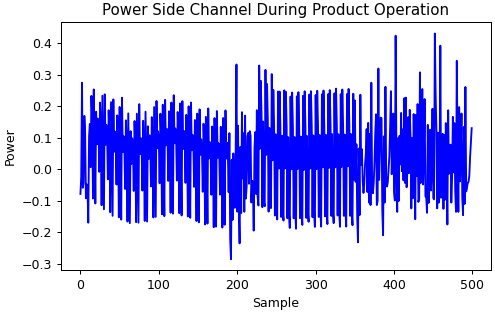

In [69]:
randlist1 = list(np.random.randint(low = 1,high=8,size=16))
randlist2 = list(np.random.randint(low = 1,high=8,size=16))
trace_list_a = []


i = 0
while i < 32:
    trace = get_pwr_trace(randlist1, 'a')
    trace_list_a.append(trace)
    i = i + 1
np_list_a = np.asarray(trace_list_a)
sample_wise_a = np_list_a.mean(axis=0)
avg_sample_a = np.average(sample_wise_a)
std_sample_a = np.std(sample_wise_a)

print("Avg: ", avg_sample_a)
print("Std: ", std_sample_a)


# makes new empty plot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)
# figsize: (width, height) in inches.
# constrained_layout: makes sures the plot fits tight within the image boundaries.

# plots the data
plt.plot(sample_wise_a, color="b")

# format your plots
plt.title("Power Side Channel During Product Operation")            # adds title
plt.xlabel("Sample")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/tvla_a.pdf")

# show the plot on your screen
plt.show()
    

### Data 2 Trace

Repeat with a second data:

For each of the 32 iterations, send the same second test data each time to `tvla_test_A`, and append this to a list. Convert the trace list to numpy arrays. Average (sample-wise) the traces, and plot them using pyplot. Compute and report the mean and standard deviation for this average trace.

Avg:  0.038891845703125
Std:  0.13968493877405416


<IPython.core.display.Javascript object>


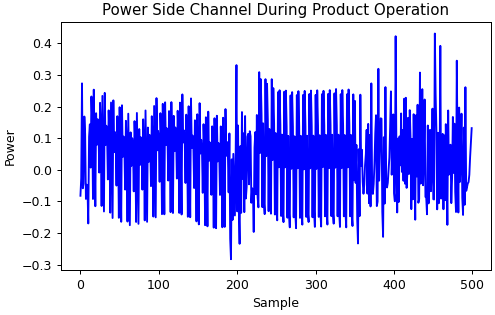

In [70]:
trace_list_a2 = []

i = 0
while i < 32:
    trace = get_pwr_trace(randlist2, 'a')
    trace_list_a2.append(trace)
    i = i + 1
np_list_a2 = np.asarray(trace_list_a2)
sample_wise_a2 = np_list_a2.mean(axis=0)
avg_sample_a2 = np.average(sample_wise_a2)
std_sample_a2 = np.std(sample_wise_a2)

print("Avg: ", avg_sample_a2)
print("Std: ", std_sample_a2)


# makes new empty plot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)
# figsize: (width, height) in inches.
# constrained_layout: makes sures the plot fits tight within the image boundaries.

# plots the data
plt.plot(sample_wise_a2, color="b")

# format your plots
plt.title("Power Side Channel During Product Operation")            # adds title
plt.xlabel("Sample")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/tvla_a2.pdf")

# show the plot on your screen
plt.show()


### Differential Trace

Subtract the two traces (from Data 1 and Data 2) to generate a differential trace; plot this separately. Compute and report the mean and standard deviation for this differential trace.

Differential Trace Mean:  -0.000220947265625
Differential Trace StD:  0.006526589346025197


<IPython.core.display.Javascript object>


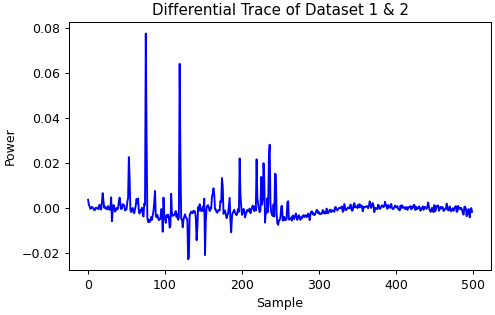

In [78]:
diffa = np.subtract(sample_wise_a, sample_wise_a2)
mean_diffa = np.mean(diffa)
std_diffa = np.std(diffa)

print("Differential Trace Mean: ", mean_diffa)
print("Differential Trace StD: ", std_diffa)

# makes new empty plot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)
# figsize: (width, height) in inches.
# constrained_layout: makes sures the plot fits tight within the image boundaries.

# plots the data
plt.plot(diffa, color="b")

# format your plots
plt.title("Differential Trace of Dataset 1 & 2")            # adds title
plt.xlabel("Sample")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/tvla_a_diff.pdf")

# show the plot on your screen
plt.show()

## tvla_test_B

Repeat for `tvla_test_B`.

### Data 1 Trace

For each of the 32 iterations, send the same first test data each time to `tvla_test_B`, and append this to a list. Convert the trace list to numpy arrays. Average (sample-wise) the traces, and plot them using pyplot. Compute and report the mean and standard deviation for this average trace.

Avg:  0.0396953125
Std:  0.1353824120215745


<IPython.core.display.Javascript object>


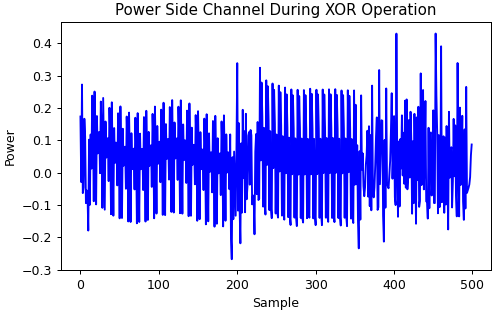

In [71]:
trace_list_b = []


i = 0
while i < 32:
    trace = get_pwr_trace(randlist1, 'b')
    trace_list_b.append(trace)
    i = i + 1
np_list_b = np.asarray(trace_list_b)
sample_wise_b = np_list_b.mean(axis=0)
avg_sample_b = np.average(sample_wise_b)
std_sample_b = np.std(sample_wise_b)

print("Avg: ", avg_sample_b)
print("Std: ", std_sample_b)


# makes new empty plot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)
# figsize: (width, height) in inches.
# constrained_layout: makes sures the plot fits tight within the image boundaries.

# plots the data
plt.plot(sample_wise_b, color="b")

# format your plots
plt.title("Power Side Channel During XOR Operation")            # adds title
plt.xlabel("Sample")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/tvla_b.pdf")

# show the plot on your screen
plt.show()

### Data 2 Trace

Repeat with a second data:

For each of the 32 iterations, send the same second test data each time to `tvla_test_B`, and append this to a list. Convert the trace list to numpy arrays. Average (sample-wise) the traces, and plot them using pyplot. Compute and report the mean and standard deviation for this average trace.

Avg:  0.03965283203125
Std:  0.13509215875536024


<IPython.core.display.Javascript object>


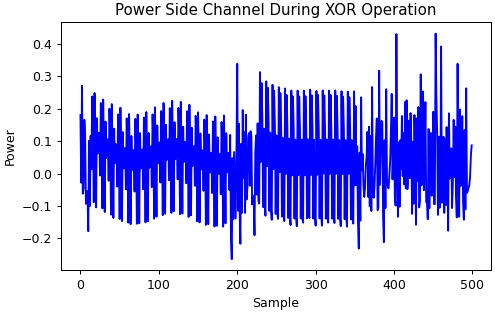

In [73]:
trace_list_b2 = []


i = 0
while i < 32:
    trace = get_pwr_trace(randlist2, 'b')
    trace_list_b2.append(trace)
    i = i + 1
np_list_b2 = np.asarray(trace_list_b2)
sample_wise_b2 = np_list_b2.mean(axis=0)
avg_sample_b2 = np.average(sample_wise_b2)
std_sample_b2 = np.std(sample_wise_b2)

print("Avg: ", avg_sample_b2)
print("Std: ", std_sample_b2)


# makes new empty plot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)
# figsize: (width, height) in inches.
# constrained_layout: makes sures the plot fits tight within the image boundaries.

# plots the data
plt.plot(sample_wise_b2, color="b")

# format your plots
plt.title("Power Side Channel During XOR Operation")            # adds title
plt.xlabel("Sample")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/tvla_b2.pdf")

# show the plot on your screen
plt.show()

### Differential Trace

Subtract the two traces (from Data 1 and Data 2) to generate a differential trace; plot this separately. Compute and report the mean and standard deviation for this differential trace.

Differential Trace Mean:  4.248046875e-05
Differential Trace StD:  0.002146171401222629


<IPython.core.display.Javascript object>


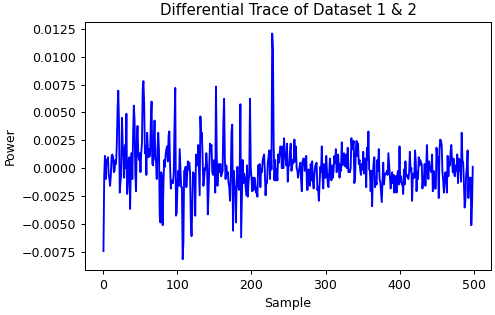

In [79]:
diffb = np.subtract(sample_wise_b, sample_wise_b2)
mean_diffb = np.mean(diffb)
std_diffb = np.std(diffb)

print("Differential Trace Mean: ", mean_diffb)
print("Differential Trace StD: ", std_diffb)

# makes new empty plot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)
# figsize: (width, height) in inches.
# constrained_layout: makes sures the plot fits tight within the image boundaries.

# plots the data
plt.plot(diffb, color="b")

# format your plots
plt.title("Differential Trace of Dataset 1 & 2")            # adds title
plt.xlabel("Sample")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/tvla_b_diff.pdf")

# show the plot on your screen
plt.show()

## tvla_test_C (graduate students only)

Repeat for `tvla_test_C`.

### Data 1 Trace

For each of the 32 iterations, send the same first test data each time to `tvla_test_C`, and append this to a list. Convert the trace list to numpy arrays. Average (sample-wise) the traces, and plot them using pyplot. Compute and report the mean and standard deviation for this average trace.

Avg:  0.0394052734375
Std:  0.12170368669022505


<IPython.core.display.Javascript object>


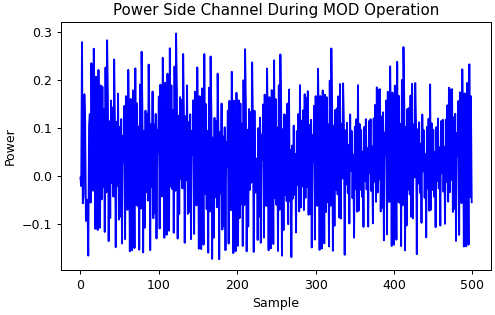

In [74]:
trace_list_c = []


i = 0
while i < 32:
    trace = get_pwr_trace(randlist1, 'c')
    trace_list_c.append(trace)
    i = i + 1
np_list_c = np.asarray(trace_list_c)
sample_wise_c = np_list_c.mean(axis=0)
avg_sample_c = np.average(sample_wise_c)
std_sample_c = np.std(sample_wise_c)

print("Avg: ", avg_sample_c)
print("Std: ", std_sample_c)

# makes new empty plot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)
# figsize: (width, height) in inches.
# constrained_layout: makes sures the plot fits tight within the image boundaries.

# plots the data
plt.plot(sample_wise_c, color="b")

# format your plots
plt.title("Power Side Channel During MOD Operation")            # adds title
plt.xlabel("Sample")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/tvla_c.pdf")

# show the plot on your screen
plt.show()

### Data 2 Trace

Repeat with a second data:

For each of the 32 iterations, send the same second test data each time to `tvla_test_C`, and append this to a list. Convert the trace list to numpy arrays. Average (sample-wise) the traces, and plot them using pyplot. Compute and report the mean and standard deviation for this average trace.

Avg:  0.039177001953125
Std:  0.1255195593037457


<IPython.core.display.Javascript object>


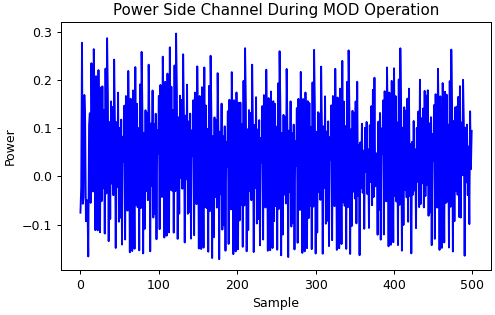

In [75]:
trace_list_c2 = []


i = 0
while i < 32:
    trace = get_pwr_trace(randlist2, 'c')
    trace_list_c2.append(trace)
    i = i + 1
np_list_c2 = np.asarray(trace_list_c2)
sample_wise_c2 = np_list_c2.mean(axis=0)
avg_sample_c2 = np.average(sample_wise_c2)
std_sample_c2 = np.std(sample_wise_c2)

print("Avg: ", avg_sample_c2)
print("Std: ", std_sample_c2)

# makes new empty plot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)
# figsize: (width, height) in inches.
# constrained_layout: makes sures the plot fits tight within the image boundaries.

# plots the data
plt.plot(sample_wise_c2, color="b")

# format your plots
plt.title("Power Side Channel During MOD Operation")            # adds title
plt.xlabel("Sample")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/tvla_c2.pdf")

# show the plot on your screen
plt.show()

### Differential Trace

Subtract the two traces (from Data 1 and Data 2) to generate a differential trace; plot this separately. Compute and report the mean and standard deviation for this differential trace.

Differential Trace Mean:  0.000228271484375
Differential Trace StD:  0.13092411620970093


<IPython.core.display.Javascript object>


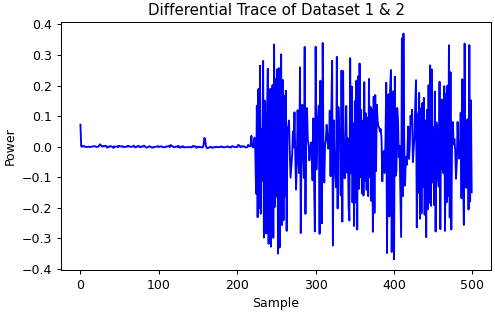

In [80]:
diffc = np.subtract(sample_wise_c, sample_wise_c2)
mean_diffc = np.mean(diffc)
std_diffc = np.std(diffc)

print("Differential Trace Mean: ", mean_diffc)
print("Differential Trace StD: ", std_diffc)

# makes new empty plot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)
# figsize: (width, height) in inches.
# constrained_layout: makes sures the plot fits tight within the image boundaries.

# plots the data
plt.plot(diffc, color="b")

# format your plots
plt.title("Differential Trace of Dataset 1 & 2")            # adds title
plt.xlabel("Sample")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/tvla_c_diff.pdf")

# show the plot on your screen
plt.show()

# Statistical Analysis

Now that you captured multiple traces, then the next goal is to analyze the traces for any potential information leakage with a statistical hypothesis test (SHT).

Using scipy, perform Welch's t-test for each function (note the optional equal\_var parameter!): https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

Note also that this function returns a pair of values `t` and `p`.

## tvla_test_A

Perform SHT analysis on `tvla_test_A`.

### Welch's t-test for Trace A

Perform the Welch's t-test between the original pair of 32 traces from the `tvla_test_A`. Get the `t` and `p` values.

Note: these are not the sample-wise average power lists.

In [49]:
t, p = sp.ttest_ind(trace_list_a, trace_list_a2)

### Mean and standard deviation for the `t` values.

Get the mean and standard deviation for the `t` values you just got.

Note: the `t` values list may have `nan` values. Use `np.nanmean` and `np.nanstd` to get the mean and standard deviation values, respectively, while ignoring those `nan` values.

In [50]:
t_mean = np.nanmean(t)
t_std = np.nanstd(t)
print(t_mean)
print(t_std)

-1.2559716158134682
13.673368991992175


### Plot t-values

Plot the `t` values you just got.

<IPython.core.display.Javascript object>


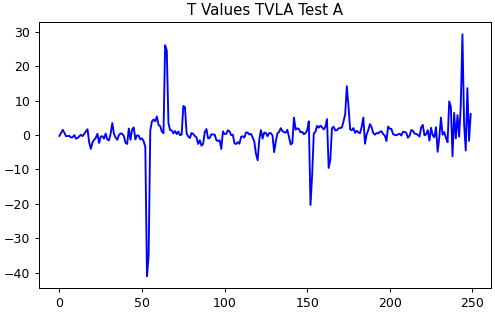

In [51]:
# trace_A1[i][0:250] and trace_A2[i][0:250]

# makes new empty plot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)
# figsize: (width, height) in inches.
# constrained_layout: makes sures the plot fits tight within the image boundaries.

# plots the data
plt.plot(t[0:250], color="b")

# format your plots
plt.title("T Values TVLA Test A")            # adds title
# plt.xlabel("Sample")  # adds x-axis label
# plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/tvla_a_t.pdf")

# show the plot on your screen
plt.show()

### Get percentage of statistical significance

Get the percentage of `p`-values you just got which indicate statistical significance at the 5% threshold (i.e. are below 0.05).

In [52]:
num_p = np.asarray(p)
count = np.count_nonzero(num_p < 0.05)
percent = count/len(num_p)
print("Percent p: ", percent*100, "%")

Percent p:  52.800000000000004 %


## tvla_test_B

Perform SHT analysis on `tvla_test_B`.

### Welch's t-test for Trace B

Perform the Welch's t-test between the original pair of 32 traces from the `tvla_test_B`. Get the `t` and `p` values.

Note: these are not the sample-wise average power lists.

In [53]:
t, p = sp.ttest_ind(trace_list_b, trace_list_b2)

### Mean and standard deviation for the `t` values.

Get the mean and standard deviation for the `t` values you just got.

Note: the `t` values list may have `nan` values. Use `np.nanmean` and `np.nanstd` to get the mean and standard deviation values, respectively, while ignoring those `nan` values.

In [54]:
t_mean = np.nanmean(t)
t_std = np.nanstd(t)
print(t_mean)
print(t_std)

0.08492254571142817
1.0654708891347842


### Plot t-values

Plot the `t` values you just got.

<IPython.core.display.Javascript object>


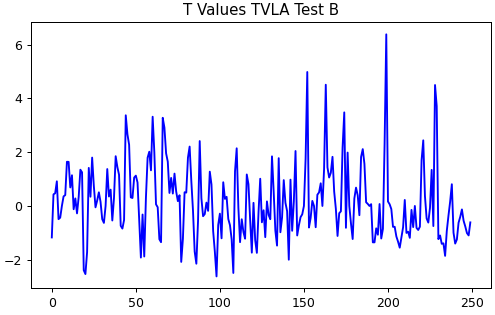

In [55]:
# makes new empty plot
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)
# figsize: (width, height) in inches.
# constrained_layout: makes sures the plot fits tight within the image boundaries.

# plots the data
plt.plot(t[0:250], color="b")

# format your plots
plt.title("T Values TVLA Test B")            # adds title
# plt.xlabel("Sample")  # adds x-axis label
# plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/tvla_b_t.pdf")

# show the plot on your screen
plt.show()

### Get percentage of statistical significance

Get the percentage of `p`-values you just got which indicate statistical significance at the 5% threshold (i.e. are below 0.05).

In [56]:
num_p = np.asarray(p)
count = np.count_nonzero(num_p < 0.05)
percent = count/len(num_p)
print("Percent p: ", percent * 100, "%")

Percent p:  5.4 %


## tvla_test_C (graduate students only)

Perform SHT analysis on `tvla_test_C`.

### Welch's t-test for Trace C

Perform the Welch's t-test between the original pair of 32 traces from the `tvla_test_C`. Get the `t` and `p` values.

Note: these are not the sample-wise average power lists.

In [57]:
t, p = sp.ttest_ind(trace_list_c, trace_list_c2)

### Mean and standard deviation for the `t` values.

Get the mean and standard deviation for the `t` values you just got.

Note: the `t` values list may have `nan` values. Use `np.nanmean` and `np.nanstd` to get the mean and standard deviation values, respectively, while ignoring those `nan` values.

In [58]:
t_mean = np.nanmean(t)
t_std = np.nanstd(t)
print(t_mean)
print(t_std)

-0.19530393418330885
70.33580042461975


### Plot t-values

Plot the `t` values you just got.

<IPython.core.display.Javascript object>


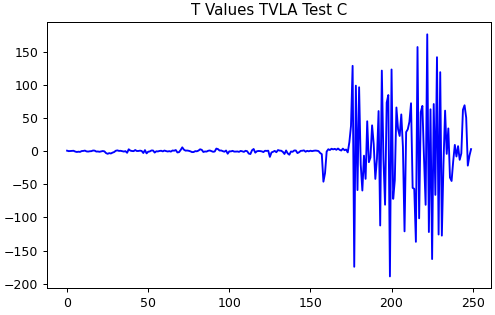

In [59]:
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)
# figsize: (width, height) in inches.
# constrained_layout: makes sures the plot fits tight within the image boundaries.

# plots the data
plt.plot(t[0:250], color="b")

# format your plots
plt.title("T Values TVLA Test C")            # adds title
# plt.xlabel("Sample")  # adds x-axis label
# plt.ylabel("Power")          # adds y-axis label
# ... and more ...

# saves the plot
plt.savefig("../Figures/tvla_c_t.pdf")

# show the plot on your screen
plt.show()

### Get percentage of statistical significance

Get the percentage of `p`-values you just got which indicate statistical significance at the 5% threshold (i.e. are below 0.05).

In [60]:
num_p = np.asarray(p)
count = np.count_nonzero(num_p < 0.05)
percent = count/len(num_p)
print("Percent p: ", percent*100, "%")

Percent p:  71.8 %


# Diconnect Scope/Target

Disconnect the CW's scope and target:

In [40]:
scope.dis()
target.dis()